<a href="https://colab.research.google.com/github/Reevoc/Tesi/blob/main/Tumori_Benigni_Maligni_25GB_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Network

###Librerie Importate




In [19]:
import numpy as np 
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab.patches import cv2_imshow

from google.colab import drive
from tensorflow.python.client import device_lib
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras import backend

####Installazioni


In [20]:
!pip install pyyaml h5py

#**Preparazione e download delle immagini**
Le immagini vengono scaricate da google drive, e convertite in array numpy.
Il dataset è composto da 4 cartelle già divise per tumori benigni e maligni per test e train.

In [21]:
def change_name(cartella, sottocartella):
  x = 0
  for i in os.listdir(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}'): 
      if  i.endswith(".jpg"):
        path = os.path.join(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}', i)
        path_destination = os.path.join(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}', "photo" + str(x) + ".jpg")
        os.rename(path, path_destination)
      x+=1

In [22]:
#change_name(test , malignant) 

In [23]:
drive.mount('/content/drive', force_remount = True)

folder_benign_train = '/content/drive/MyDrive/Dati/train/benign'
folder_malignant_train = '/content/drive/MyDrive/Dati/train/malignant'

folder_benign_test = '/content/drive/MyDrive/Dati/test/benign'
folder_malignant_test = '/content/drive/MyDrive/Dati/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
print("train beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')
print("train maligni caricati")

# Carico le immagini di test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
print("test beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')
print("test maligni caricati")

Mounted at /content/drive
train beningi caricati
train maligni caricati
test beningi caricati
test maligni caricati


###Aggiungo le Lables 
Aggiungo la lables a tutte le immagini 0 per un benigno e 1 per un maligno.
Concateno i set di train e di test e faccio uno shuffle delle dei tensori

In [24]:
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [25]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


#Shuffle
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

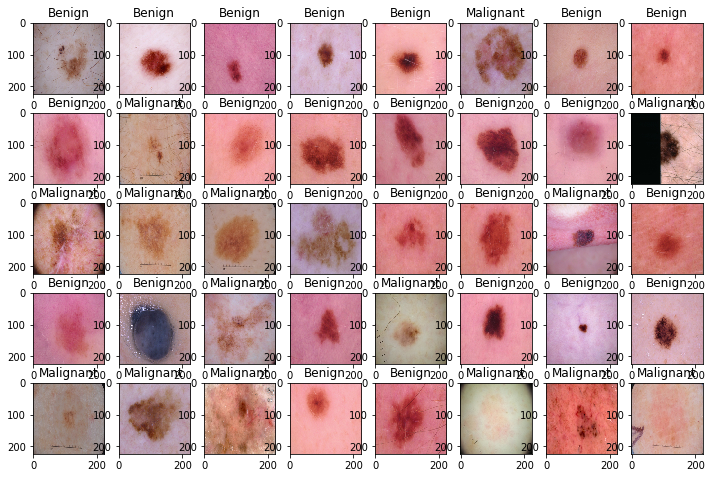

In [26]:
columns = 8
rows = 5
fig=plt.figure(figsize=(12, 8))

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation= 'nearest')
plt.show()

###Lables Categoriche

In [27]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test =tf.keras.utils.to_categorical(y_test, num_classes=2)

###Normalizzo 

In [28]:
X_train = X_train/255.0
X_test = X_test/255.0
X_train.shape

(2637, 224, 224, 3)

#Costruisco il modello di CNN_model
Il modello è basato su dei layer di Conv2D, e MaxPool2D.
Viene aggiunto anche un layer di dropout per evitare un overfitting della rete.
dopo varie prove ho optato per un'attivazione sigmoid e ottimizzatore rsmprop o softmax attivatore e adam ottimizzatore. Questi sembrano dare i risultati migliori

In [29]:
#in optin da provare con rmsprop , adam e in activation_Dense con sigmoid , softmax
def CNN_model(input_shape, lr, numclassi, optim, activ): 
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), padding = 'valid',activation = 'relu', input_shape = input_shape, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))#metto questo stato di dropout per evitare un overfitting della rete 
    model.add(layers.Conv2D(64, (3,3), padding = 'valid' ,activation = 'relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.25))
    model.add(layers.Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(numclassi, activation='softmax'))
    #Scegli l'ottimizzatore
    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)
    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer , loss = "binary_crossentropy",metrics=['accuracy']
                  )
    
    model.summary()
    return model


###Learning rate reduction


In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience=5,  verbose=1, factor=0.5,  min_lr=1e-7)

###Graficazione
plot il modello in base ai valori di loss e accuracy ottenuti dal test train in fase di CNN_model

In [31]:
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']  
  val_loss = history.history['val_loss']
  epoches = range (1, len(acc)+1)

  plt.plot(epoches, acc, 'bo', label ='Traning accuracy')
  plt.plot(epoches, val_acc, 'b', label ='Validation accuracy')
  plt.title('Traning and Validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epoches, loss, 'bo', label = 'Traning loss')
  plt.plot(epoches, val_loss, 'b', label ='Validation loss')
  plt.title('Traning and Validation loss')
  plt.legend()

  plt.show()

#Addestro il modello 

In [32]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 100
batch_size = 256 #influenza la velocità del modello 

model = CNN_model(lr=lr,numclassi = 2, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction])
plot(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 186624)           

###sdsdsdsd

In [33]:
def train_generator(epochs, batch_size):
  train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

  train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Dati/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
  
  return train_generator

def validation_generator(epochs, batch_size):
  
  test_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Dati/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
  
  return validation_generator

def fit_model(train_generator, validation_generator, batch_size, epochs, model):
  history = model.fit(train_generator,
          validation_data = validation_generator,
          steps_per_epoch = len(X_train)//batch_size,
          validation_steps = len(X_test)//batch_size,
          callbacks = [learning_rate_reduction],
          batch_size = batch_size,
          verbose= 1,
          epochs=epochs)
  plot(history)
  backend.clear_session()
  del model
  del history

###Valori da cambiare

In [34]:
epochs = 100
batch_size = 256
input_shape = (224, 224, 3)
lr = 1e-5
optim = 'relu'
activ = 'adam'

In [37]:
train_generator = train_generator(epochs, batch_size)
validation_generator = validation_generator(epochs, batch_size)

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
64
64
(224, 224, 3)
(224, 224, 3)
2
2


In [ ]:
fit_model(train_generator, validation_generator , batch_size, epochs, model)

Epoch 1/70
41/41 [==============================] - 37s 891ms/step - loss: 0.4718 - accuracy: 0.7664 - val_loss: 0.5152 - val_accuracy: 0.7594
Epoch 2/70
41/41 [==============================] - 36s 882ms/step - loss: 0.4747 - accuracy: 0.7637 - val_loss: 0.5172 - val_accuracy: 0.7594
Epoch 3/70
41/41 [==============================] - 36s 877ms/step - loss: 0.4770 - accuracy: 0.7625 - val_loss: 0.5161 - val_accuracy: 0.7656
Epoch 4/70
41/41 [==============================] - 37s 890ms/step - loss: 0.4763 - accuracy: 0.7575 - val_loss: 0.5156 - val_accuracy: 0.7672
Epoch 5/70
41/41 [==============================] - 36s 882ms/step - loss: 0.4800 - accuracy: 0.7563 - val_loss: 0.5168 - val_accuracy: 0.7609
Epoch 6/70
41/41 [==============================] - 36s 881ms/step - loss: 0.4801 - accuracy: 0.7544 - val_loss: 0.5154 - val_accuracy: 0.7609
Epoch 7/70
41/41 [==============================] - 36s 884ms/step - loss: 0.4748 - accuracy: 0.7598 - val_loss: 0.5159 - val_accuracy: 0.7578

#ATTENZIONE#

In [ ]:
inputs = train_generator(model, epochs, batch_size)
targets = validation_generator(model, epochs, batch_size)


print(f'shape degli input = {inputs.shape}')
print(f'shape dei target = {targets.shape}')

#3 k fold
kfold = KFold(n_splits=3, shuffle=True)
print(f'values kfold = {kfold}')

#dove metto gli score
acc_per_fold = []
loss_per_fold = []
fold_no = 1

for train, test in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')
    print(f'Rete n = {fold_no} in esecuzione')
    
    fit_model(inputs, targets , batch_size, epochs)
    
    #score del modello in percentuale
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score per fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')

    # Increase fold number
    fold_no = fold_no + 1
    backend.clear_session()
    del model

#Media degli score
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Media degli scores per tutte le folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

#ATTENZIONE#

###Cross-Validation

In [ ]:
inputs = X_train
targets = y_train


print(f'shape degli input = {inputs.shape}')
print(f'shape dei target = {targets.shape}')

#3 k fold
kfold = KFold(n_splits=3, shuffle=True)
print(f'values kfold = {kfold}')

#dove metto gli score
acc_per_fold = []
loss_per_fold = []
fold_no = 1

for train, test in kfold.split(inputs, targets):
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')
    print(f'Rete n = {fold_no} in esecuzione')
    
    model = CNN_model((224,224,3), 1e-5, 2,'relu', 'adam')
    
    #Addestro il modello su una parte dei dati di train
    model.fit(inputs[train], targets[train], epochs=epochs, batch_size=batch_size, verbose=0)
    
    #score del modello in percentuale
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score per fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')

    # Increase fold number
    fold_no = fold_no + 1
    backend.clear_session()
    del model

#Media degli score
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Media degli scores per tutte le folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


###Testo il modello
dopo varie prove il modello in fase di test raggiunge indicativamenre un punteggio nell'intorno del 60% di accuracy


In [ ]:
model = CNN_model((224,224,3), 1e-5, 2,'relu', 'adam')

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=ReduceLROnPlateau(monitor = 'accuracy', patience=5,  verbose=1, factor=0.5,  min_lr=1e-7)
         )

# Testing model on test data to evaluate
y_pred = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))
#print((model.predict(y_test) > 0.5).astype("int32"))

In [ ]:
def save_model(epoch, generator):
  try: 
    os.mkdir('/content/drive/My Drive/GansCheckpoint/CNNh5/Cmodel%01d.h5')
  except OSError as e:
    if e.errno == errno.EEXIST:
        print('Folder not create or already exist')
  filename = '/content/drive/My Drive/GansCheckpoint/CNNNh5/Cmodel%01d.h5' %(epoch)
  generator.save(filename)

def load_model(epoch, generator):
      epoch = epoch
      filename = '/content/drive/My Drive/GansCheckpoint/CNNh5/Cmodel%01d.h5' %(self.epoch)
      generator.load_model(filename)